<h1>Salvar Vídeo de Plot</h1>

Este notebook foi desenvolvido para savar em vídeo plot dos dados.

<h4>Seleção de Dataset</h4>

In [ ]:
# Saveiro 1
folder = 'E:\\Dados Processados\\100 Hz\\2019-12-24 17-21-12 - Saveiro Cenário 1\\'
ini = parseDateToTimestamp("2019-12-24T17:21:14")
end = parseDateToTimestamp("2019-12-24T17:43:48")

<h4>Importação de Pacotes</h4>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import datetime
from dateutil import parser
from tqdm import tqdm, tqdm_notebook
from multiprocessing import Process
from threading import Thread 
%matplotlib notebook
# %matplotlib inline
# plt.rcParams['animation.html'] = 'jshtml'

<h4>Funções Utilitárias</h4>

In [3]:
# Transforma Date String em Timestamp Int
def parseDateToTimestamp(value):
    newDate = parser.parse(value)
    return datetime.timestamp(newDate)

# Transforma Timestamp Int em Date String 
def parseTimestampToDate(value):
    newDate = datetime.fromtimestamp(value)
    return newDate.strftime("%Y-%m-%dT%H:%M:%S")

# Cria a Pasta se Ainda Não Existir
def createFolder(path):
    
    if not os.path.exists(path):
        os.makedirs(path)

<h4>Importação dos Dados</h4>

In [5]:
iniVideo = parseDateToTimestamp(ini)
endVideo = parseDateToTimestamp(end)
data_esquerda = pd.read_csv(folder + 'dataset_gps_mpu_left.csv', float_precision="high")
data_direita = pd.read_csv(folder + 'dataset_gps_mpu_right.csv', float_precision="high")

<h4>Definição de Parâmetros</h4>

In [6]:
# Conjunto de Dados de Trabalho
data = data_esquerda # data_direita
file = folder + "dataset_left.mp4" # folder + "dataset_right.mp4"

# Corta Dados
iniIndex = data[data['timestamp'] == iniVideo].index.values[0]
endIndex = data[data['timestamp'] == endVideo].index.values[0]
data = data[iniIndex : endIndex + 1]

# Quantidade de dados por vez na tela
window = 100

# Tamanho do Data Set
size = len(data)

# Intervalo de tempo entre as amostras - em milisegundos
interval = round(1000 * (data['timestamp'].values[-1] - data['timestamp'].values[0]) / size)

# Frames por segundo
fps = round(1000 / interval)

<h4>Inicialização do plot</h4>

In [7]:
speedColor = 'k'
dashboardColor = 'r'
belowSuspensionColor = 'g'
aboveSuspensionColor = 'b'

speedLabel = 'Speed'
dashboardLabel = 'Dashboard'
belowSuspensionLabel = 'Below Suspension'
aboveSuspensionLabel = 'Above Suspension'

xPoints = np.arange(len(data))

axesAll = []
linesAll = []
sourcesAll = []

index = 0
    
def getSpeedLimit():
    return [data['speed'].min(), data['speed'].max()]
    
def getAccLimit():

    min_value = min(
        data['acc_x_below_suspension'].min(),
        data['acc_y_below_suspension'].min(),
        data['acc_z_below_suspension'].min(),
        data['acc_x_above_suspension'].min(),
        data['acc_y_above_suspension'].min(),
        data['acc_z_above_suspension'].min(),
        data['acc_x_dashboard'].min(),
        data['acc_y_dashboard'].min(),
        data['acc_z_dashboard'].min()
    )

    max_value = max(
        data['acc_x_below_suspension'].max(),
        data['acc_y_below_suspension'].max(),
        data['acc_z_below_suspension'].max(),
        data['acc_x_above_suspension'].max(),
        data['acc_y_above_suspension'].max(),
        data['acc_z_above_suspension'].max(),
        data['acc_x_dashboard'].max(),
        data['acc_y_dashboard'].max(),
        data['acc_z_dashboard'].max()
    )

    return [min_value, max_value]
    
def getGyroLimit():

    min_value = min(
        data['gyro_x_below_suspension'].min(),
        data['gyro_y_below_suspension'].min(),
        data['gyro_z_below_suspension'].min(),
        data['gyro_x_above_suspension'].min(),
        data['gyro_y_above_suspension'].min(),
        data['gyro_z_above_suspension'].min(),
        data['gyro_x_dashboard'].min(),
        data['gyro_y_dashboard'].min(),
        data['gyro_z_dashboard'].min()
    )

    max_value = max(
        data['gyro_x_below_suspension'].max(),
        data['gyro_y_below_suspension'].max(),
        data['gyro_z_below_suspension'].max(),
        data['gyro_x_above_suspension'].max(),
        data['gyro_y_above_suspension'].max(),
        data['gyro_z_above_suspension'].max(),
        data['gyro_x_dashboard'].max(),
        data['gyro_y_dashboard'].max(),
        data['gyro_z_dashboard'].max()
    )

    return [min_value, max_value]
    
def getMagLimit():

    min_value = min(
        data['mag_x_above_suspension'].min(),
        data['mag_y_above_suspension'].min(),
        data['mag_z_above_suspension'].min(),
        data['mag_x_dashboard'].min(),
        data['mag_y_dashboard'].min(),
        data['mag_z_dashboard'].min()
    )

    max_value = max(
        data['mag_x_above_suspension'].max(),
        data['mag_y_above_suspension'].max(),
        data['mag_z_above_suspension'].max(),
        data['mag_x_dashboard'].max(),
        data['mag_y_dashboard'].max(),
        data['mag_z_dashboard'].max()
    )

    return [min_value, max_value]

def createSubPlotSpeed(ylim=None):

    print(fig)
    
    axes = fig.add_subplot(gs[0, 0:2])
    axes.set_title('')
    axes.set_xlabel('Sample Number')
    axes.set_ylabel('Speed (m/s)')

    if not(ylim is None):
        axes.set_ylim(ylim[0], ylim[1])

    xdata = xPoints
    ydata = data['speed']
    line, = axes.plot(xdata, ydata, color=speedColor, label=speedLabel) 

    axesAll.append(axes)
    linesAll.append(line)
    sourcesAll.append(ydata)

    return axes, [line]

def createSubPlot(loc=None, title='', ylabel='', xlabel='', field='', ylim=None):

    lines = []
    sources = []

    axes = fig.add_subplot(gs[loc[0], loc[1]])
    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)

    if not(ylim is None):
        axes.set_ylim(ylim[0], ylim[1])

    if not(field.startswith('mag')):
        xdata = xPoints
        ydata = data[field + '_below_suspension']
        line, = axes.plot(xdata, ydata, color=belowSuspensionColor, label=belowSuspensionLabel)
        sources.append(ydata)
        lines.append(line)

    xdata = xPoints
    ydata = data[field + '_above_suspension']
    line, = axes.plot(xdata, ydata, color=aboveSuspensionColor, label=aboveSuspensionLabel)
    sources.append(ydata)
    lines.append(line)

    xdata = xPoints
    ydata = data[field + '_dashboard']
    line, = axes.plot(xdata, ydata, color=dashboardColor, label=dashboardLabel)
    sources.append(ydata)
    lines.append(line)

    axesAll.append(axes)

    for i in range(0, len(lines)):
        linesAll.append(lines[i])

    for i in range(0, len(sources)):
        sourcesAll.append(sources[i])

    return axes, lines

def create():
    
    global fig
    global gs
    global index
    
    fig = plt.figure(index, figsize=(19.20, 10.80), constrained_layout=True)
    index += 1
    # fig.subplots_adjust(hspace=0.2, wspace=0.2)
    gs = fig.add_gridspec(nrows=4, ncols=3, wspace=0.4, hspace=0.4)

    limSpeed = getSpeedLimit()
    limAcc = getAccLimit()
    limGyro = getGyroLimit()
    limMag = getMagLimit()

    axesSpeed, linesSpeed = createSubPlotSpeed(ylim=limSpeed)

    axesGyroX, linesGyroX = createSubPlot(loc=[1,0], field='gyro_x', title='X-Axis', ylim=limGyro, ylabel='Rotation Rate (°/s)')
    axesGyroY, linesGyroY = createSubPlot(loc=[1,1], field='gyro_y', title='Y-Axis', ylim=limGyro)
    axesGyroZ, linesGyroZ = createSubPlot(loc=[1,2], field='gyro_z', title='Z-Axis', ylim=limGyro)

    axesAccX, linesAccX = createSubPlot(loc=[2,0], field='acc_x', ylim=limAcc, ylabel='Acceleration (m/s²)')
    axesAccY, linesAccY = createSubPlot(loc=[2,1], field='acc_y', ylim=limAcc)
    axesAccZ, linesAccZ = createSubPlot(loc=[2,2], field='acc_z', ylim=limAcc)

    axesMagX, linesMagX = createSubPlot(loc=[3,0], xlabel='Sample Number', field='mag_x', ylim=limMag, ylabel='Magnetic Field (μT)')
    axesMagY, linesMagY = createSubPlot(loc=[3,1], xlabel='Sample Number', field='mag_y', ylim=limMag)
    axesMagZ, linesMagZ = createSubPlot(loc=[3,2], xlabel='Sample Number', field='mag_z', ylim=limMag)

    axesLegend = fig.add_subplot(gs[0, 2])
    axesLegend.set_axis_off()
    legend = axesLegend.legend(handles=linesAll[0:4], loc='center')

# Limpa todas as linhas
def clear():

    for i in range(0, len(linesAll)):
        linesAll[i].set_data([], [])

# Desenha dados do ponto i
def point(i, load_bar):

    plot_left = max(0, i - window)
    plot_right = max(1, i)

    for j in range(0, len(axesAll)):
        axesAll[j].set_xlim(left=plot_left, right=plot_right)

    start = max(0, i - window)
    end = min(i + 1, len(xPoints))

    for j in range(0, len(linesAll)):
        xdata = xPoints[start:end]
        ydata = sourcesAll[j][start: end]
        linesAll[j].set_data(xdata, ydata)

    load_bar.update(1)

# Plot no Notebook
def show(part, count, load_bar):

    clear()
    fig.show()

    start = part * count

    for i in range(0, count):
        point(start + i, load_bar)   
        fig.canvas.draw()

# Plot para video
def save(part, count, load_bar):

    linesTuple = tuple(linesAll)
    start = part * count

    def init():
        clear()
        return linesTuple

    def animate(i):
        point(start + i, load_bar)
        # fig.canvas.draw()
        return linesTuple

    anim = FuncAnimation(fig, animate, init_func=init, frames=count, interval=interval, repeat=False) # blit=True,
    anim.save(file, fps=fps, extra_args=['-vcodec', 'libx264'])

<IPython.core.display.Javascript object>


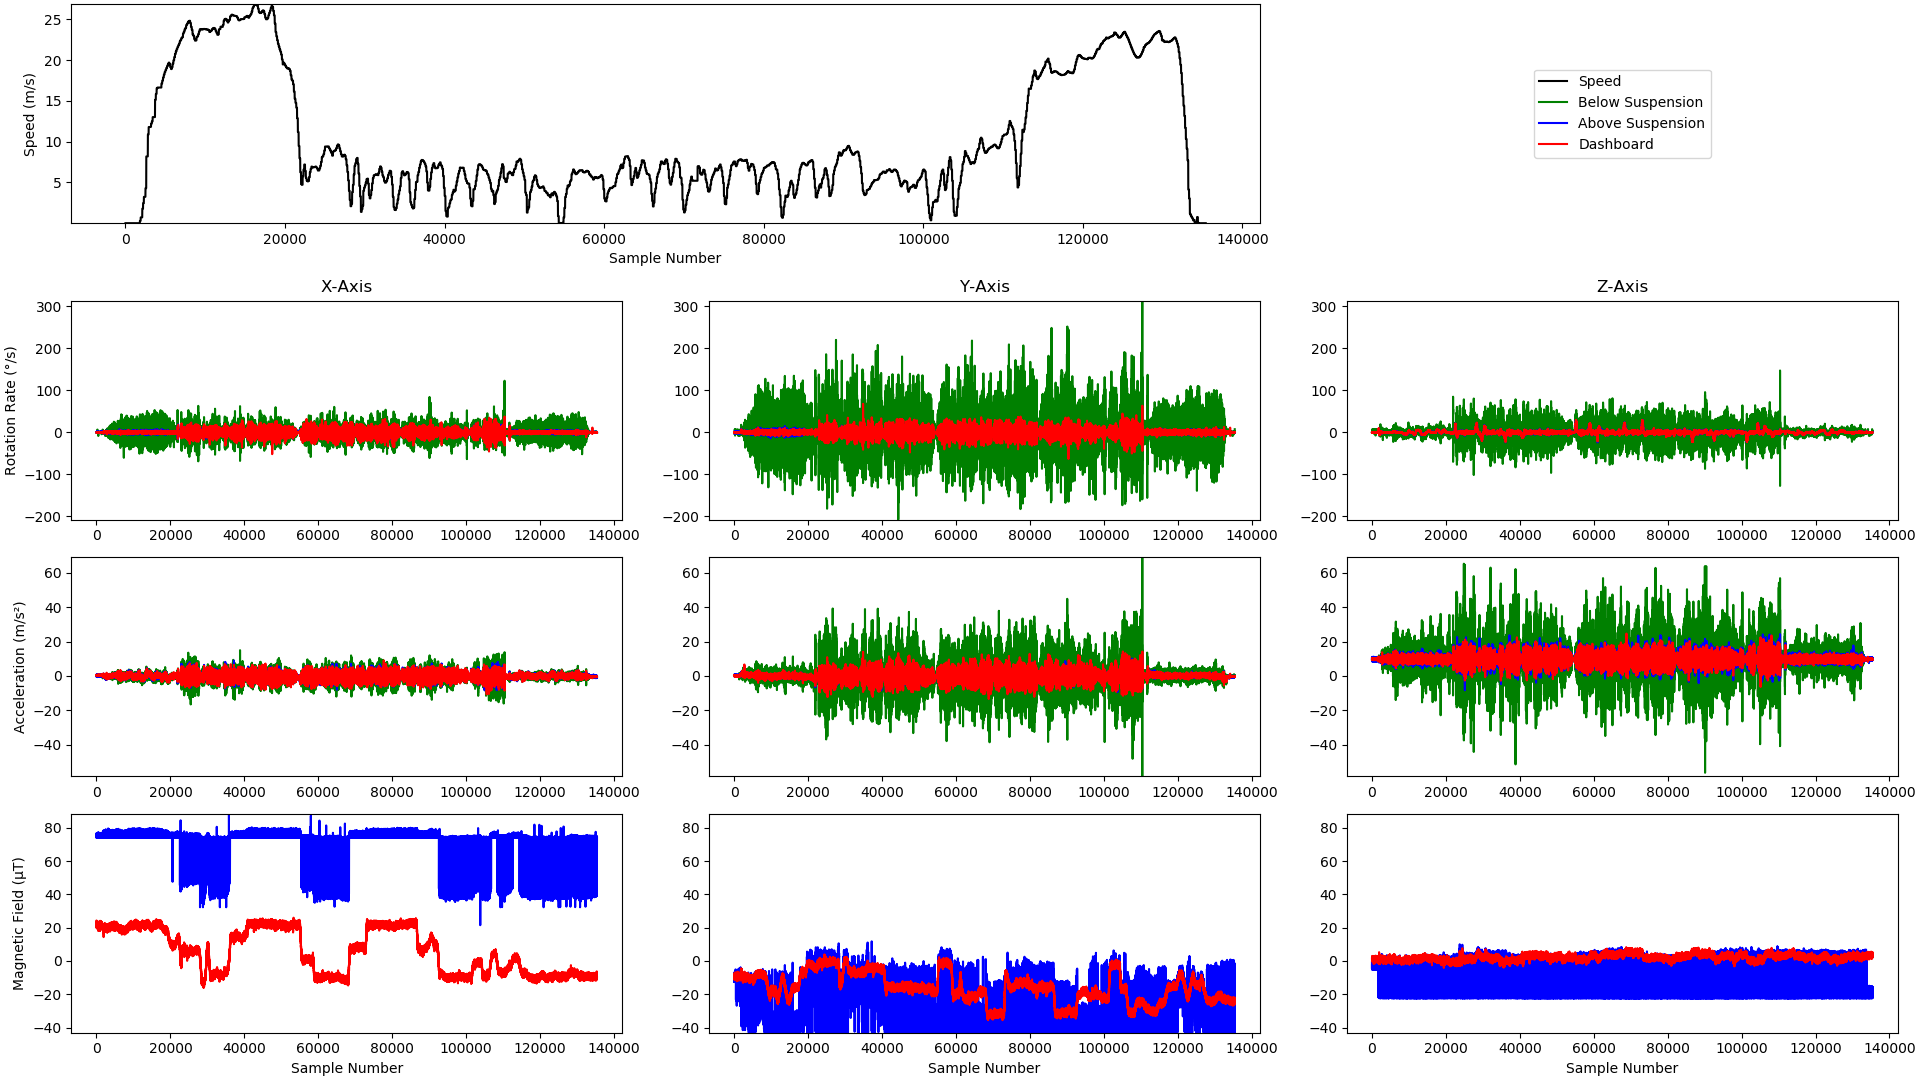

Figure(1920x1080)


In [8]:
create()

In [ ]:
save(0, size, tqdm_notebook(total=size))

In [ ]:
# p = Process(target=save, args=(0, size, tqdm_notebook(total=size)))
# p = Thread(target=save, args=(0, size, tqdm_notebook(total=size)))
# p.start()

In [ ]:
plt.close()